# CatBoost model

CatBoost — это библиотека градиентного бустинга, созданная Яндексом. Она использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. По сравнению с классическими деревьями, небрежные деревья более эффективны при реализации на процессоре и просты в обучении.

In [1]:
import os
import gc
import itertools
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
start = datetime.now()

Прочитаем подготовленные чанки с данными:

In [4]:
path_to_dataset = 'data/processed_data/train'

dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                        if filename.startswith('processed_chunk')])

frames = []

for step, chunk_path in enumerate(dataset_paths):
    print(f'{step}. chunk_path {chunk_path}')
    frames.append(pd.read_parquet(chunk_path, columns=None))

df = pd.concat(frames, axis=0).fillna(0.)
X, y = df.drop(['id', 'flag'], axis=1), df['flag']
del df, frames
gc.collect()

0. chunk_path data/processed_data/train/processed_chunk_000.parquet
1. chunk_path data/processed_data/train/processed_chunk_001.parquet
2. chunk_path data/processed_data/train/processed_chunk_002.parquet
3. chunk_path data/processed_data/train/processed_chunk_003.parquet
4. chunk_path data/processed_data/train/processed_chunk_004.parquet
5. chunk_path data/processed_data/train/processed_chunk_005.parquet
6. chunk_path data/processed_data/train/processed_chunk_006.parquet
7. chunk_path data/processed_data/train/processed_chunk_007.parquet
8. chunk_path data/processed_data/train/processed_chunk_008.parquet
9. chunk_path data/processed_data/train/processed_chunk_009.parquet
10. chunk_path data/processed_data/train/processed_chunk_010.parquet
11. chunk_path data/processed_data/train/processed_chunk_011.parquet


0

# Обучим модель без учета весов классов:

In [5]:
scores = []

In [6]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=7, l2_leaf_reg=9, 
                              bootstrap_type='Bayesian', loss_function='Logloss', eval_metric='AUC',
                              allow_writing_files=False)
catboost.fit(X, y)

0:	total: 289ms	remaining: 4m 49s
1:	total: 456ms	remaining: 3m 47s
2:	total: 618ms	remaining: 3m 25s
3:	total: 796ms	remaining: 3m 18s
4:	total: 970ms	remaining: 3m 13s
5:	total: 1.16s	remaining: 3m 12s
6:	total: 1.31s	remaining: 3m 6s
7:	total: 1.47s	remaining: 3m 2s
8:	total: 1.65s	remaining: 3m 1s
9:	total: 1.82s	remaining: 2m 59s
10:	total: 1.94s	remaining: 2m 54s
11:	total: 2.13s	remaining: 2m 55s
12:	total: 2.28s	remaining: 2m 52s
13:	total: 2.44s	remaining: 2m 52s
14:	total: 2.58s	remaining: 2m 49s
15:	total: 2.75s	remaining: 2m 49s
16:	total: 2.89s	remaining: 2m 47s
17:	total: 3.07s	remaining: 2m 47s
18:	total: 3.25s	remaining: 2m 47s
19:	total: 3.42s	remaining: 2m 47s
20:	total: 3.58s	remaining: 2m 46s
21:	total: 3.71s	remaining: 2m 44s
22:	total: 3.85s	remaining: 2m 43s
23:	total: 4.03s	remaining: 2m 43s
24:	total: 4.2s	remaining: 2m 43s
25:	total: 4.38s	remaining: 2m 43s
26:	total: 4.54s	remaining: 2m 43s
27:	total: 4.68s	remaining: 2m 42s
28:	total: 4.83s	remaining: 2m 41s

Прочитаем чанк с тестовыми данными:

In [7]:
data = pd.read_parquet('data/processed_data/test/test.parquet', columns=None).head(100000)
data.head()

,id,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_1,pre_loans3060_1,pre_loans3060_3,pre_loans3060_4,pre_loans6090_1,pre_loans5_10,pre_loans530_17
42594,42594,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168419,168419,1.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58629,58629,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222749,222749,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90249,90249,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X_test = data.drop(['id', 'flag'], axis=1)
y_test = data['flag']

In [9]:
y_pred = catboost.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     96811
           1       1.00      0.00      0.00      3189

    accuracy                           0.97    100000
   macro avg       0.98      0.50      0.49    100000
weighted avg       0.97      0.97      0.95    100000



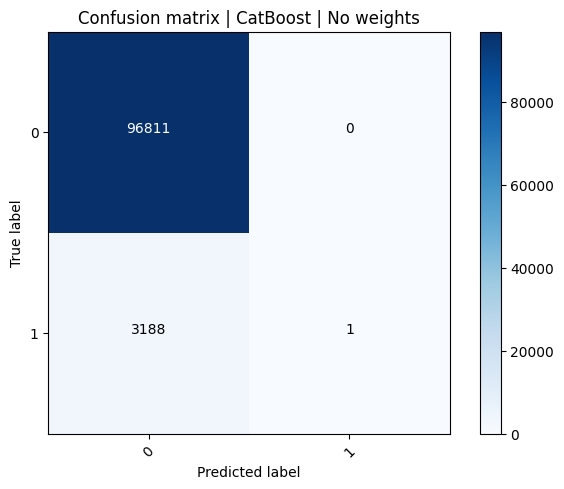

In [11]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix | CatBoost | No weights')
plt.savefig('pictures/CatBoost_model_1.png', bbox_inches='tight');

**Модель хорошо помечает положительные классы, так что на каждого пропущенного мошенника приходится в среднем 2.6 верно определенных мошенников. При этом модель ошибается на отрицательном классе, но это допустимо в задачах банкинга.**

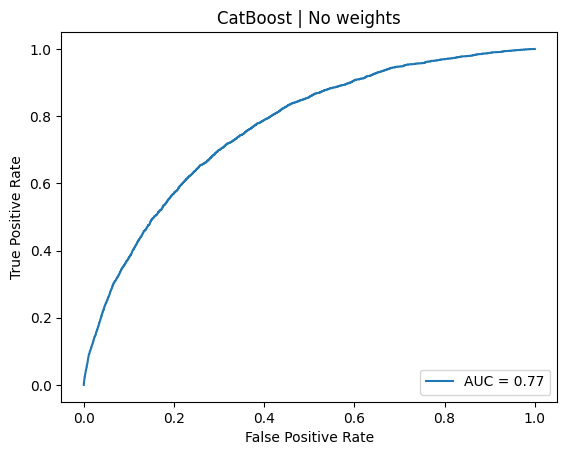

In [12]:
# Посчитаем значение метрики AUC и построим ROC кривую
y_pred_proba = catboost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('CatBoost | No weights')
plt.savefig('pictures/CatBoost_model_2.png', bbox_inches='tight');

**Значение метрики auc получилось выше целевого, что можно взять за основу в продакшене.**

# Обучим модель с учетом весов классов:

In [13]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=7, l2_leaf_reg=9, 
                              bootstrap_type='Bayesian', loss_function='Logloss', eval_metric='AUC', 
                              auto_class_weights='Balanced', allow_writing_files=False)
catboost.fit(X, y)

0:	total: 269ms	remaining: 4m 28s
1:	total: 531ms	remaining: 4m 24s
2:	total: 792ms	remaining: 4m 23s
3:	total: 1.07s	remaining: 4m 26s
4:	total: 1.33s	remaining: 4m 24s
5:	total: 1.6s	remaining: 4m 25s
6:	total: 1.87s	remaining: 4m 25s
7:	total: 2.13s	remaining: 4m 23s
8:	total: 2.4s	remaining: 4m 24s
9:	total: 2.7s	remaining: 4m 26s
10:	total: 2.97s	remaining: 4m 27s
11:	total: 3.25s	remaining: 4m 27s
12:	total: 3.55s	remaining: 4m 29s
13:	total: 3.82s	remaining: 4m 29s
14:	total: 4.1s	remaining: 4m 29s
15:	total: 4.37s	remaining: 4m 28s
16:	total: 4.63s	remaining: 4m 28s
17:	total: 4.89s	remaining: 4m 26s
18:	total: 5.15s	remaining: 4m 25s
19:	total: 5.43s	remaining: 4m 26s
20:	total: 5.7s	remaining: 4m 25s
21:	total: 5.98s	remaining: 4m 25s
22:	total: 6.26s	remaining: 4m 26s
23:	total: 6.53s	remaining: 4m 25s
24:	total: 6.79s	remaining: 4m 24s
25:	total: 7.06s	remaining: 4m 24s
26:	total: 7.32s	remaining: 4m 23s
27:	total: 7.61s	remaining: 4m 24s
28:	total: 7.89s	remaining: 4m 24s


Прочитаем чанк с тестовыми данными:

In [14]:
data = pd.read_parquet('data/processed_data/test/test.parquet', columns=None).head(100000)
data.head()

,id,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_1,pre_loans3060_1,pre_loans3060_3,pre_loans3060_4,pre_loans6090_1,pre_loans5_10,pre_loans530_17
42594,42594,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168419,168419,1.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58629,58629,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222749,222749,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90249,90249,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X_test = data.drop(['id', 'flag'], axis=1)
y_test = data['flag']

In [16]:
y_pred = catboost.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     96811
           1       0.07      0.72      0.12      3189

    accuracy                           0.67    100000
   macro avg       0.53      0.70      0.46    100000
weighted avg       0.96      0.67      0.78    100000



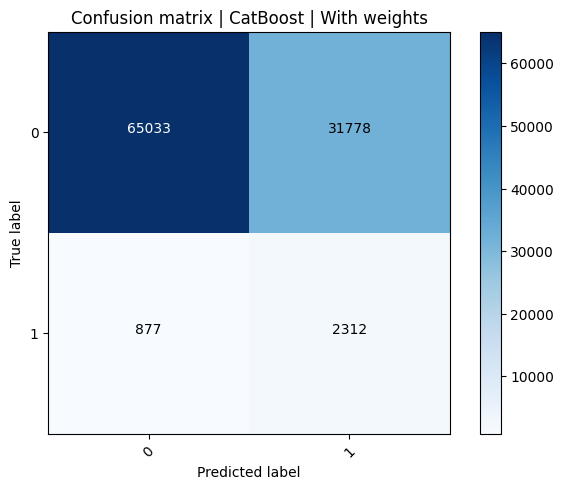

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix | CatBoost | With weights')
plt.savefig('pictures/CatBoost_model_3.png', bbox_inches='tight');

**Модель хорошо помечает положительные классы, так что на каждого пропущенного мошенника приходится в среднем 2.6 верно определенных мошенников. При этом модель ошибается на отрицательном классе, но это допустимо в задачах банкинга.**

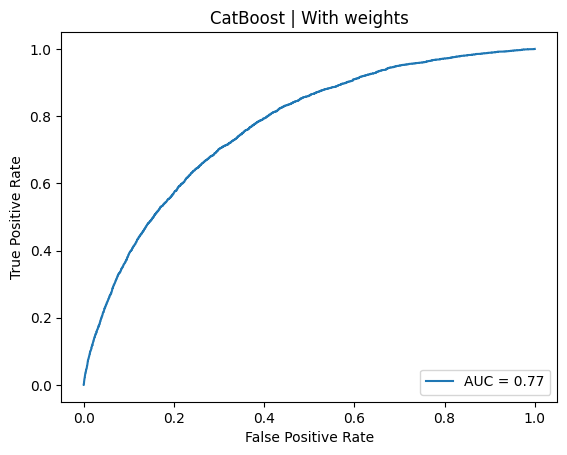

In [19]:
# Посчитаем значение метрики AUC и построим ROC кривую
y_pred_proba = catboost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('CatBoost | With weights')
plt.savefig('pictures/CatBoost_model_4.png', bbox_inches='tight');

**Значение метрики auc получилось выше целевого, что можно взять за основу в продакшене.**

# Результаты

Сохраним лучшие результаты в таблицу scores:

In [20]:
df_scores = pd.read_csv('data/scores.csv')
df_scores.loc[df_scores['model'] == 'CatBoost', 'score'] = max(scores)

time = datetime.now() - start
df_scores.loc[df_scores['model'] == 'CatBoost', 'time'] = int(time.seconds)
df_scores.head()

,model,score,time
0,Single,0.769663,216.0
1,Ensemble,0.774815,450.0
2,Linear,0.732219,602.0
3,CatBoost,0.768903,492.0
4,LightGBM,0.775573,118.0


In [21]:
df_scores.to_csv('data/scores.csv', index=False)